In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import itertools
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv("../data/processed/df1.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [37]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(exclude=['object']).columns.tolist()

print("Catégorielles :", categorical_features)
print("Numériques :", numerical_features)


Catégorielles : []
Numériques : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


<small>

Dans le cadre de cette analyse, les variables sont considérées comme **catégorielles** si elles possèdent **moins de 6 modalités uniques** ; dans le cas contraire, elles sont classées comme **numériques**.  
Une autre approche consiste à se baser directement sur le **type de données** (par exemple, `int` ou `float` pour les numériques, `object` ou `string` pour les catégorielles).  

Dans notre cas particulier (dataset Telco Churn après encodage), toutes les variables sont désormais **numériques**.  
Parmi elles, on distingue :  
- des **variables continues** (`tenure`, `MonthlyCharges`, `TotalCharges`),  
- des **variables binaires** (issues de l’encodage des modalités, ex. `gender`, `Partner`, `Contract_One year`, etc.),  
- ainsi que la **variable cible** `Churn` (0 = Non, 1 = Oui).  

Cette double approche (seuil sur le nombre de modalités + type de données) offre une séparation robuste entre variables numériques et catégorielles,  
tout en garantissant une meilleure compréhension de la structure du dataset avant d’entamer l’EDA et la modélisation.  

</small>


#### Visualisation de la Variable Cible : Churn

<small>

Comprendre la distribution de la variable cible **Churn** est essentiel pour analyser le comportement des clients.  

- **Distribution du Churn** : On observe la répartition entre les clients ayant résilié et ceux restés, afin de mesurer l’éventuel déséquilibre du dataset.  
- **Représentation visuelle** : Des graphiques (camembert et barplot) permettent de visualiser rapidement la proportion respective des deux catégories.  
- **Insights** : Cette analyse met en évidence un déséquilibre dans la classe cible, ce qui soulève des défis pour la modélisation et oriente l’importance de méthodes de rééquilibrage (ex. SMOTE, pondération des classes).  
Cette étape constitue un **point de départ fondamental** pour comprendre le dataset et préparer les analyses et modélisations futures.


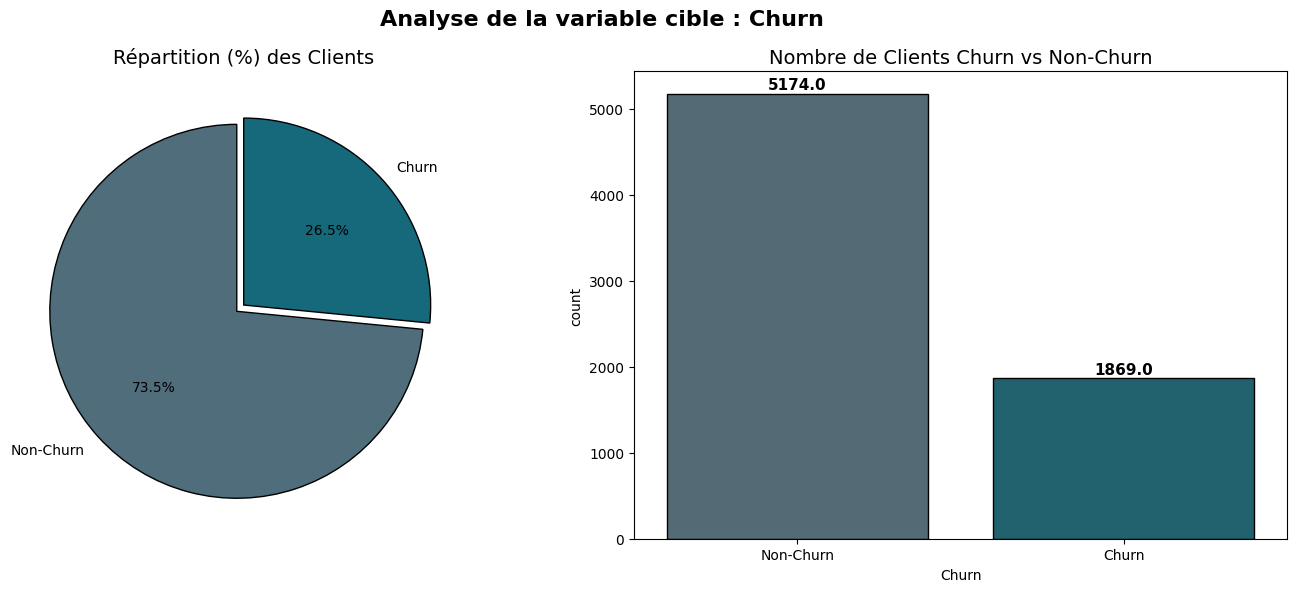

In [38]:
# Palette
colors = ['#4F6D7A', '#16697A']  

# Comptage des classes
counts = df['Churn'].value_counts()

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Camembert (%)
axes[0].pie(counts.values, labels=['Non-Churn', 'Churn'],
            autopct='%1.1f%%', startangle=90, explode=(0.05, 0),
            colors=colors, wedgeprops={'edgecolor': 'black'})
axes[0].set_title('Répartition (%) des Clients', fontsize=14)

# Barplot 
ax = sns.countplot(x='Churn', data=df, palette=colors, edgecolor='black', ax=axes[1])
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 50,  # petit offset
            f"{rect.get_height()}", ha='center', fontsize=11, fontweight='bold')
ax.set_xticklabels(['Non-Churn', 'Churn'])
ax.set_title('Nombre de Clients Churn vs Non-Churn', fontsize=14)

# 
plt.suptitle("Analyse de la variable cible : Churn", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


<small>

Le dataset présente une distribution **fortement déséquilibrée**, avec un ratio d’environ **3:1** entre les clients **Non-Churn** et les clients **Churn**.  En effet ce déséquilibre introduit un biais potentiel lors de l’entraînement.
Le modèle risque de privilégier la prédiction de la classe majoritaire (**Non-Churn**) au détriment d’une bonne détection des clients réellement à risque (**Churn**).  
Les visualisations mettent en évidence ce déséquilibre, soulignant le défi que représente cette distribution asymétrique.  
Le traitement de ce déséquilibre constituera une étape **cruciale** pour améliorer la performance du modèle, notamment en utilisant des techniques comme :  **le rééchantillonnage** (oversampling des Churn, undersampling des Non-Churn),  **SMOTE** (Synthetic Minority Oversampling Technique), 
ou encore la **pondération des classes** lors de l’apprentissage des modèles.


#### Variables Catégorielles et Leur Impact sur le Churn

<small>
Pour l’analyse, nous avons retiré la variable cible **Churn** de la liste des variables catégorielles, afin de concentrer l’exploration sur l’influence des autres attributs sur la probabilité de résiliation.

Afin de mieux organiser l’étude des nombreuses variables catégorielles, celles-ci ont été regroupées en **trois catégories principales** :

1. **Informations Client**  
   - `gender`  
   - `SeniorCitizen`  
   - `Partner`  
   - `Dependents`  

2. **Services Souscrits**  
   - `PhoneService`  
   - `MultipleLines`  
   - `InternetService`  
   - `StreamingTV`  
   - `StreamingMovies`  
   - `OnlineSecurity`  
   - `OnlineBackup`  
   - `DeviceProtection`  
   - `TechSupport`  

3. **Informations de Facturation**  
   - `Contract`  
   - `PaperlessBilling`  
   - `PaymentMethod`  

Cette classification permet une analyse plus structurée et facilite l’exploration de l’impact de chaque groupe de variables sur la probabilité de churn.  
Elle servira de base à la création de visualisations comparatives (ex. countplots ou barplots) afin de dégager les **tendances et patterns** liés à la résiliation.


In [39]:
l1 = ['gender','SeniorCitizen','Partner','Dependents'] # Customer Information
l2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] # Services Signed Up for!
l3 = ['Contract','PaperlessBilling','PaymentMethod'] # Payment Information

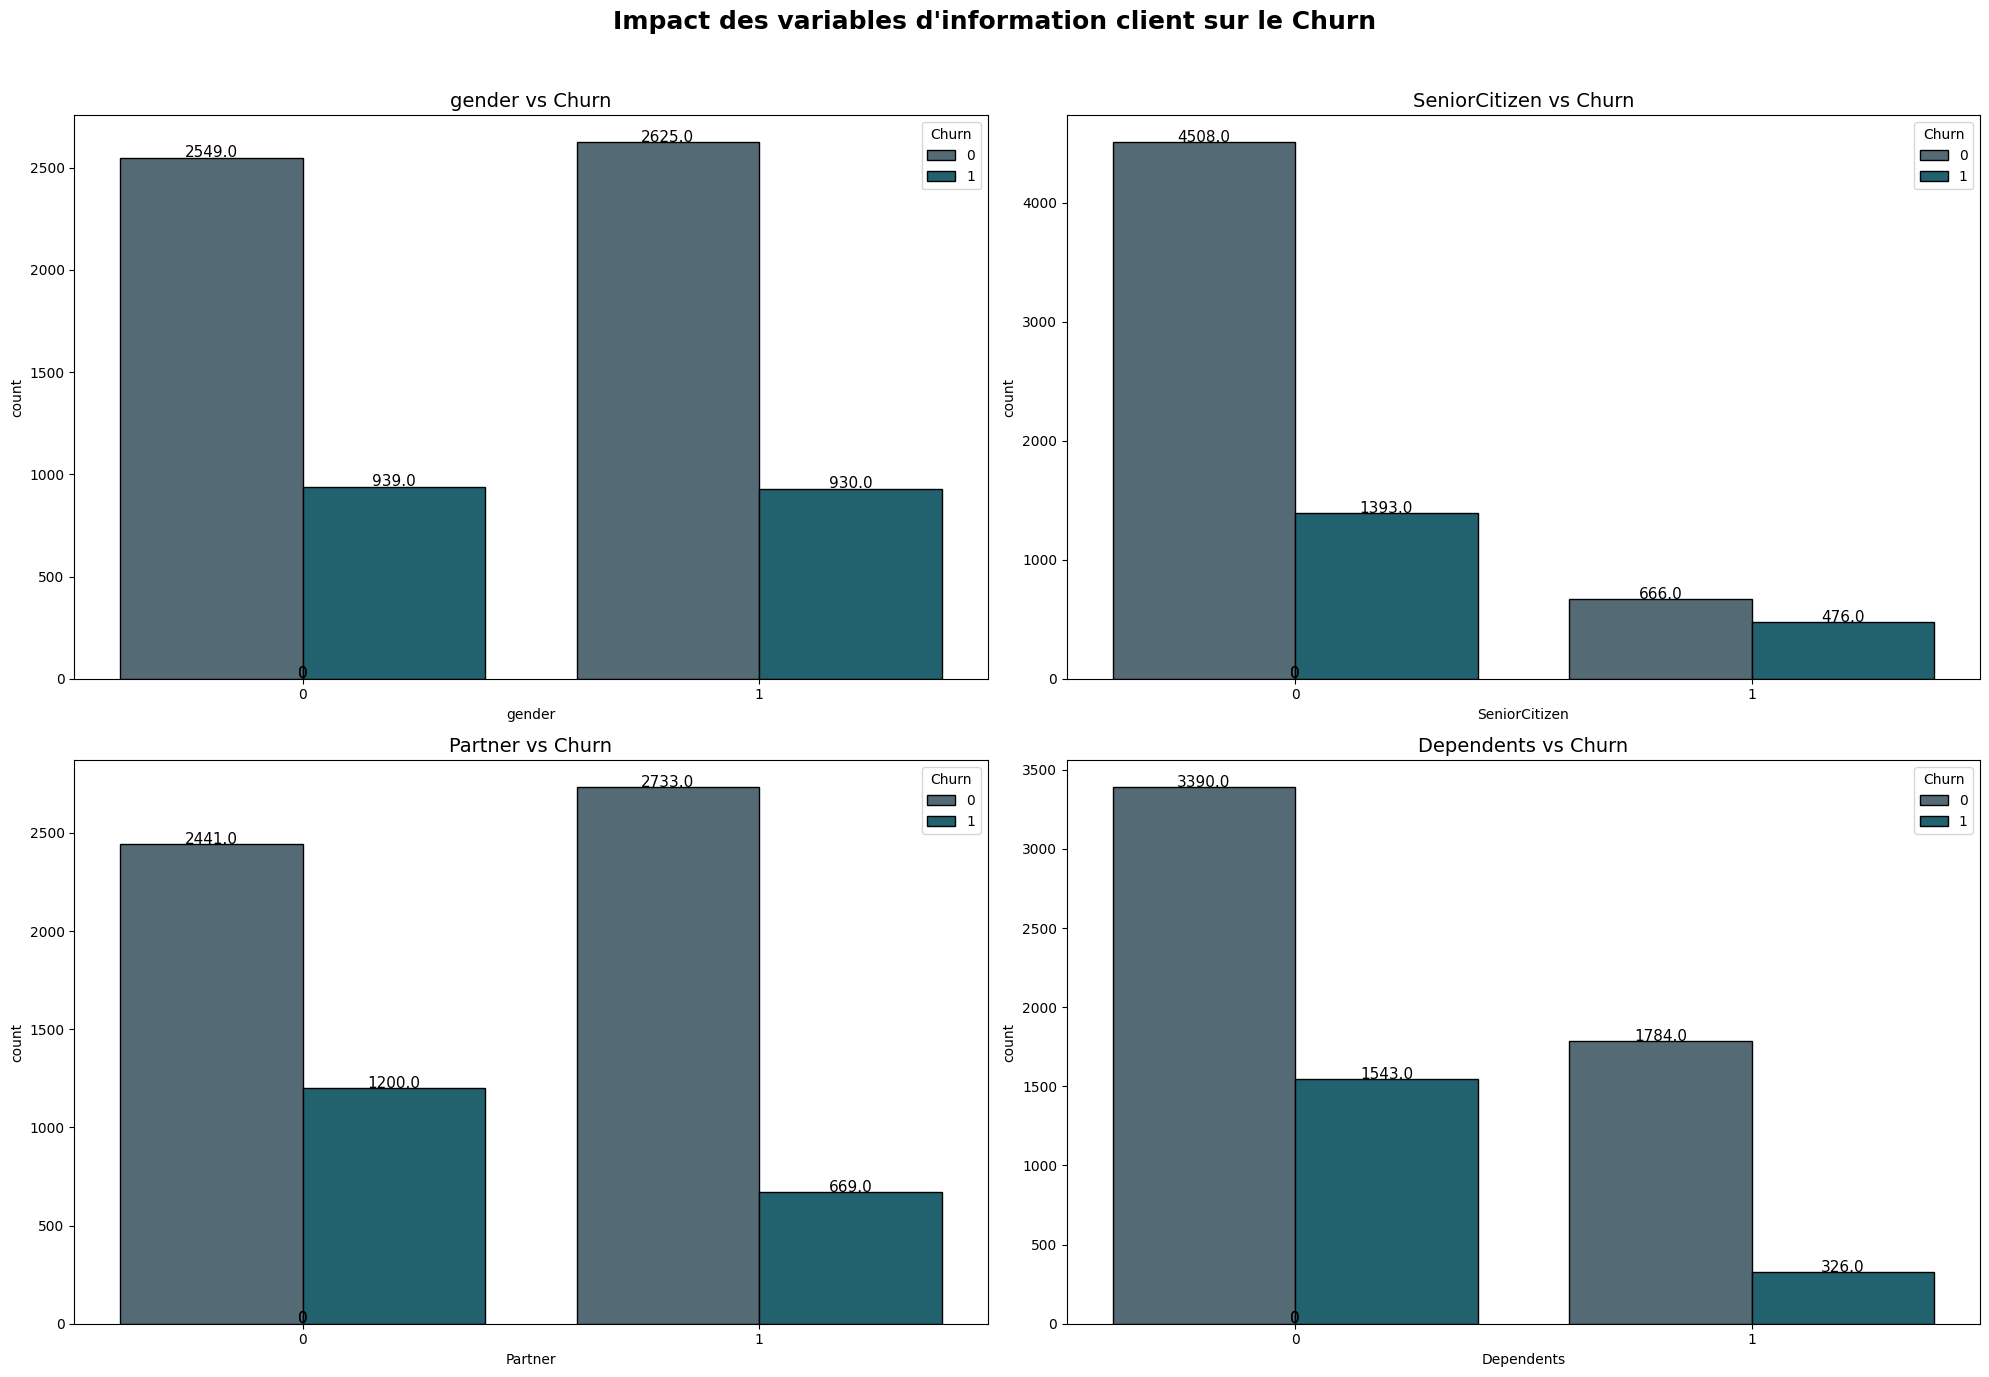

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

for i, col in enumerate(l1):
    ax = axes[i // 2, i % 2]  # navigation automatique dans la grille
    
    sns.countplot(x=col, data=df, hue="Churn", palette=colors,
                  edgecolor="black", ax=ax)
    
    # Ajout des annotations au-dessus des barres
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2,
                rect.get_height() + 2,
                rect.get_height(),
                ha='center', fontsize=11)
    
    ax.set_title(f"{col} vs Churn", fontsize=14)

plt.suptitle("Impact des variables d'information client sur le Churn", 
             fontsize=18, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # pour laisser de la place au titre global
plt.show()


<small>

#### Impact des Variables d’Information Client sur le Churn


- **Gender** : La répartition hommes/femmes est relativement équilibrée et n’a pas d’impact significatif sur le churn.  
- **SeniorCitizen** : Les clients seniors présentent un taux de churn proportionnellement plus élevé que les non-seniors.  
- **Partner** : Les clients sans partenaire ont tendance à résilier davantage que ceux ayant un partenaire.  
- **Dependents** : Les clients sans personnes à charge affichent un taux de churn plus élevé que ceux avec des personnes à charge.  

Ces premières observations montrent que certains facteurs démographiques (notamment **SeniorCitizen**, **Partner** et **Dependents**) semblent jouer un rôle dans la fidélité des clients, tandis que le **genre** n’apparaît pas discriminant.


<small>

#### Groupe 2 : Services Souscrits par le Client

Pour l’analyse, nous regroupons les variables liées aux **services souscrits** par les clients.  
Ces attributs reflètent les choix en matière de communication, de connectivité et de divertissement, et permettent d’étudier l’impact de ces services sur la probabilité de churn.  

Les variables considérées sont :  
- `PhoneService`  
- `MultipleLines`  
- `InternetService`  
- `StreamingTV`  
- `StreamingMovies`  

Cette segmentation facilite une analyse ciblée du comportement des clients vis-à-vis des services utilisés, et aide à identifier des **patterns et tendances** pouvant expliquer la résiliation.


In [41]:
df.columns.tolist()

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

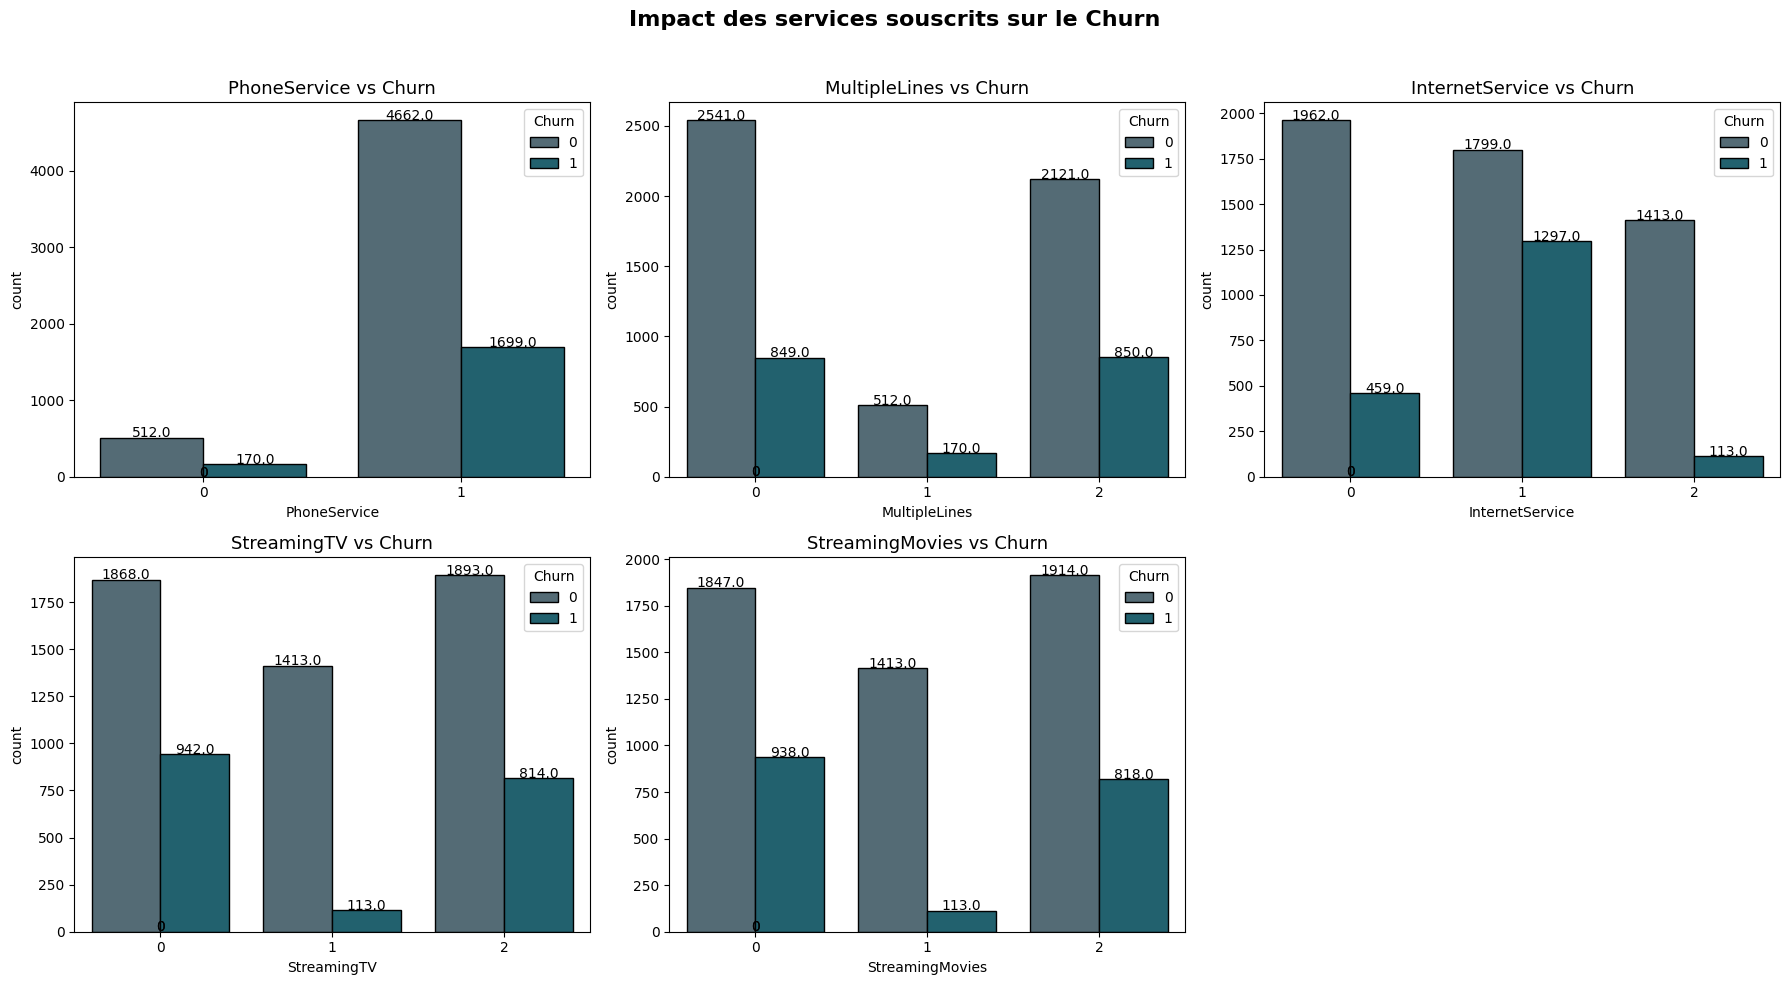

In [42]:

service_features = ['PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies']

# la grille : 2 lignes × 3 colonnes (5 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # on simplifie l'accès aux axes

for i, col in enumerate(service_features):
    ax = axes[i]
    sns.countplot(x=col, data=df, hue="Churn", palette=colors, edgecolor="black", ax=ax)

    # les annotations
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width()/2,
                rect.get_height() + 2,
                rect.get_height(),
                ha="center", fontsize=10)

    ax.set_title(f"{col} vs Churn", fontsize=13)

# Suppression du dernier subplot vide
fig.delaxes(axes[-1])

plt.suptitle("Impact des services souscrits sur le Churn", fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<small>

#### Impact des Services Souscrits sur le Churn

- **PhoneService** : La présence ou non d’un service téléphonique n’a pas d’effet majeur sur le churn. Les proportions de clients churnés et non churnés restent proches.  

- **MultipleLines** : Les clients disposant de plusieurs lignes présentent une proportion légèrement plus élevée de churn comparé à ceux avec une seule ligne.  

- **InternetService** : On observe des différences marquées selon le type d’accès internet. Les clients avec certains types de service (par ex. Fibre Optique) sont plus susceptibles de résilier que ceux utilisant des services alternatifs.  

- **StreamingTV et StreamingMovies** : La souscription aux services de streaming (TV et films) semble associée à une plus forte probabilité de churn. Cela peut refléter une tendance où les clients qui utilisent davantage de services deviennent aussi plus sensibles aux coûts mensuels, conduisant à une résiliation.  

Ces résultats montrent que les **services souscrits** influencent significativement la fidélité des clients. Ils constituent donc un axe important à prendre en compte pour la **prédiction et la prévention du churn**.


<small>

#### Groupe 2  : Services de Sécurité et d’Assistance
Cette catégorie regroupe les variables liées aux services de **sécurité** et de **support technique** auxquels les clients ont souscrit :  

- `OnlineSecurity` → service de sécurité en ligne  
- `OnlineBackup` → service de sauvegarde en ligne  
- `DeviceProtection` → protection des appareils  
- `TechSupport` → assistance technique  

L’analyse de ces variables permet de mieux comprendre comment les clients utilisent les services de protection et de support.  
Ces informations sont essentielles pour développer des stratégies visant à **améliorer la satisfaction** et à **réduire le taux de churn**.


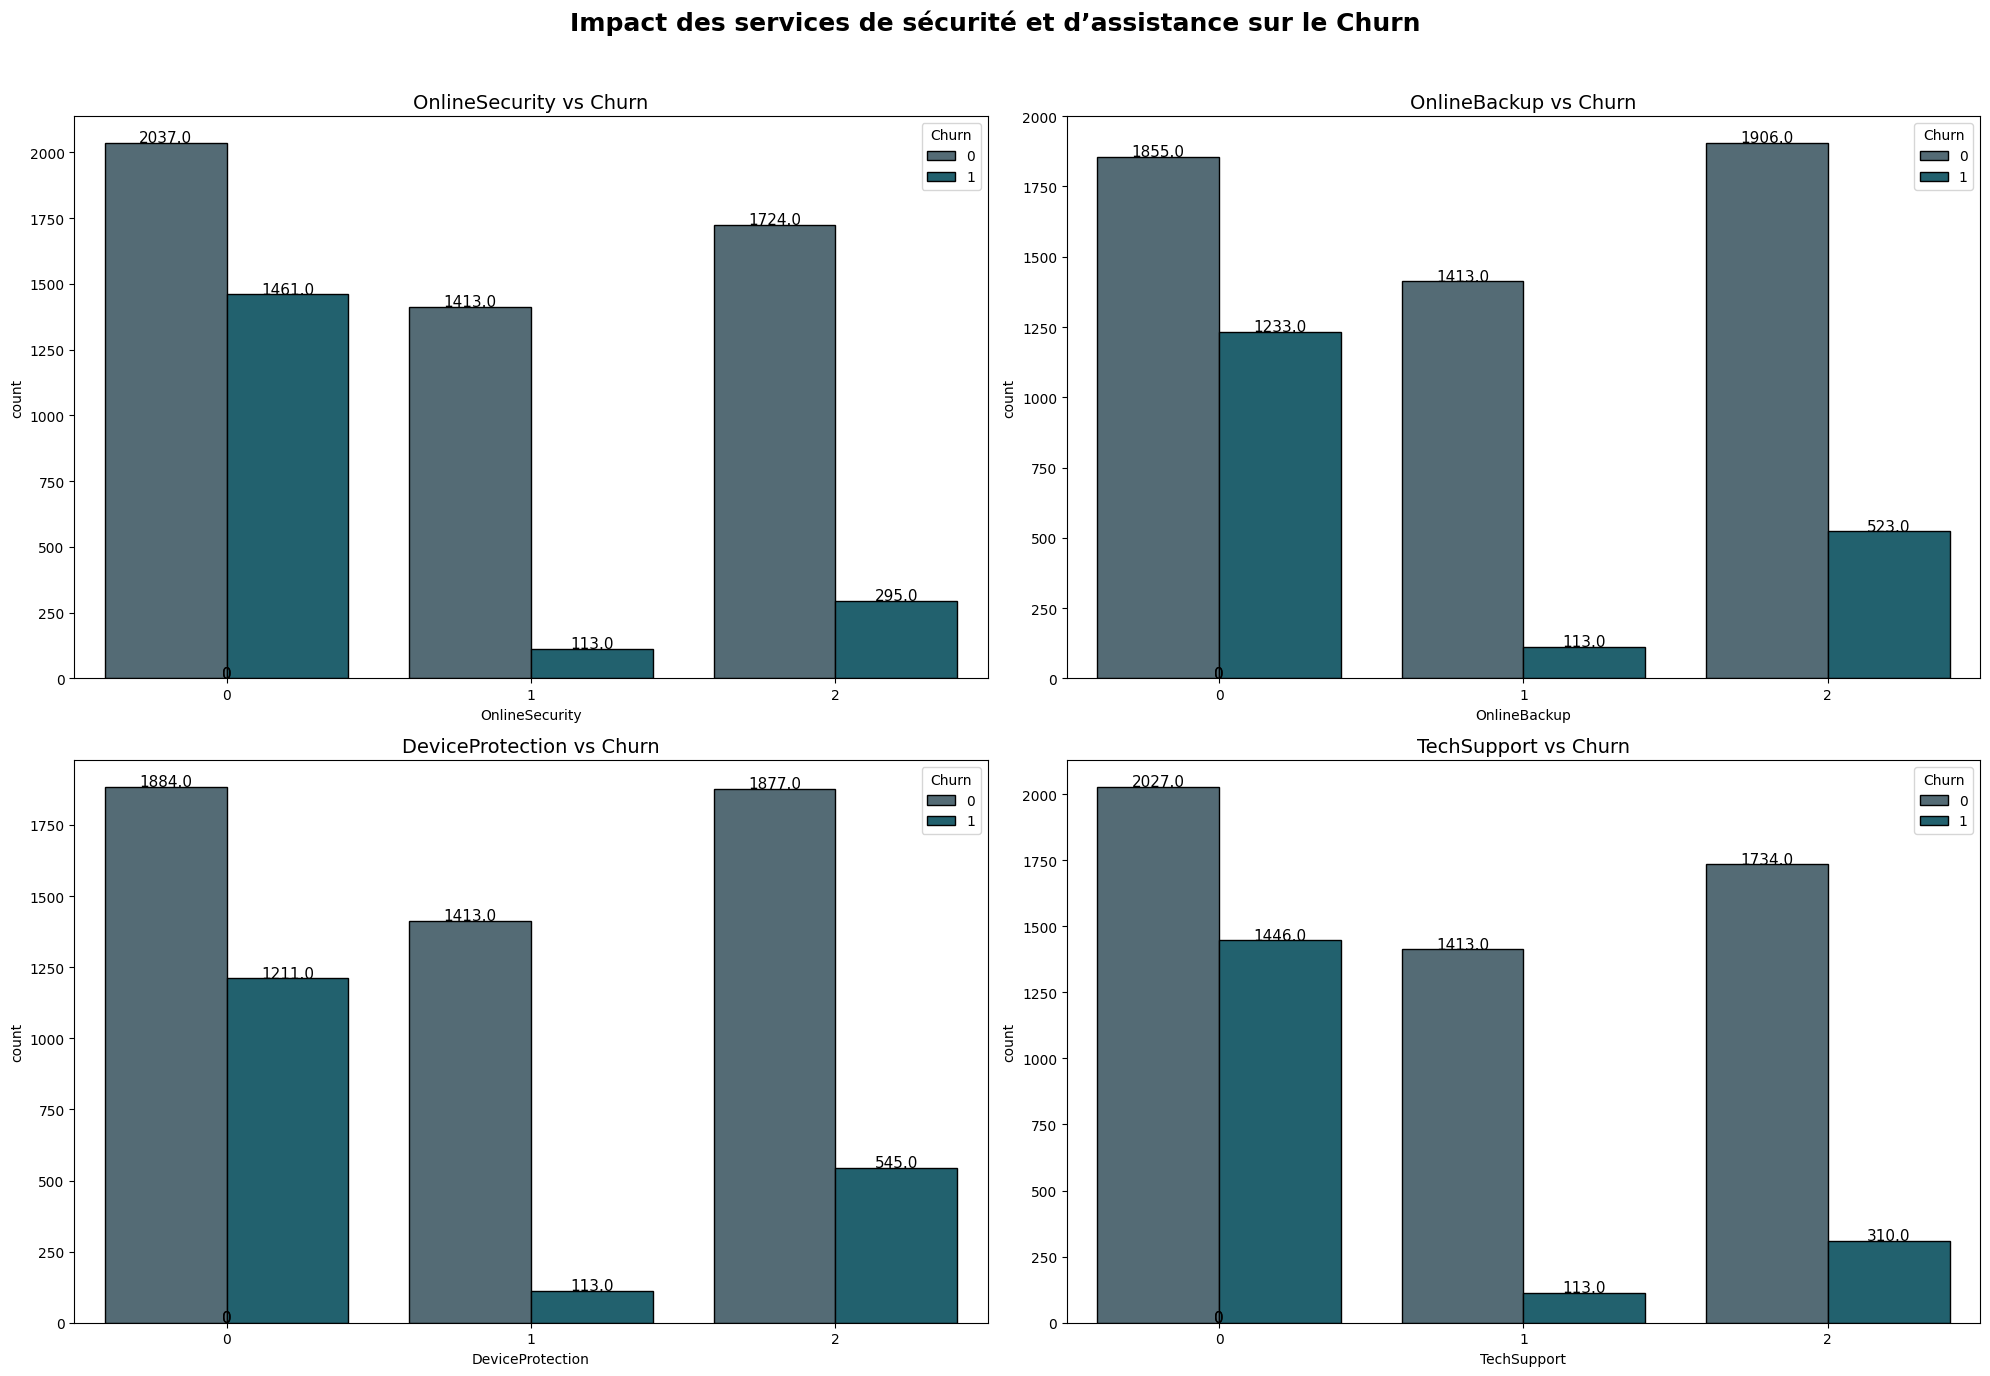

In [43]:
# Sélection des variables sécurité & support 
security_support_features = l2[-4:]

# Figure 2 x 2
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()

for i, col in enumerate(security_support_features):
    ax = axes[i]
    sns.countplot(x=col, data=df, hue="Churn", palette=colors, edgecolor="black", ax=ax)

    # Ajouter les annotations
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width()/2,
                rect.get_height() + 2,
                rect.get_height(),
                ha="center", fontsize=11)

    ax.set_title(f"{col} vs Churn", fontsize=14)

plt.suptitle("Impact des services de sécurité et d’assistance sur le Churn",
             fontsize=18, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<small>

#### Impact des Services de Sécurité et d’Assistance sur le Churn

- **OnlineSecurity** : Les clients n’ayant pas souscrit au service de sécurité en ligne présentent un taux de churn nettement plus élevé que ceux qui l’utilisent.  
- **OnlineBackup** : Les clients sans sauvegarde en ligne sont également plus susceptibles de résilier, suggérant que ce service contribue à la fidélisation.  
- **DeviceProtection** : La protection des appareils suit la même tendance : les clients bénéficiant de ce service affichent un churn plus faible.  
- **TechSupport** : L’accès au support technique réduit significativement la probabilité de churn, confirmant l’importance de l’assistance dans l’expérience client.  

Ces résultats soulignent que les services de **sécurité et de support** jouent un rôle clé dans la rétention des clients.  
Ils offrent des leviers concrets pour améliorer la satisfaction et limiter la résiliation, notamment via des offres combinées ou des campagnes de sensibilisation.


<small>

#### Groupe 3 : Informations Contractuelles et de Facturation

Ce groupe regroupe les variables liées aux **conditions contractuelles**, aux **préférences de facturation** et aux **méthodes de paiement** :  

- `Contract` → type de contrat (mensuel, un an, deux ans)  
- `PaperlessBilling` → facturation électronique ou papier  
- `PaymentMethod` → mode de paiement (chèque électronique, chèque postal, virement automatique, carte bancaire automatique)  

L’analyse de ces variables permet de mieux comprendre les préférences des clients en matière d’engagement contractuel, de facturation et de moyens de règlement.  
Elle fournit également des pistes pour adapter les offres et optimiser la **satisfaction et la rétention des clients**.


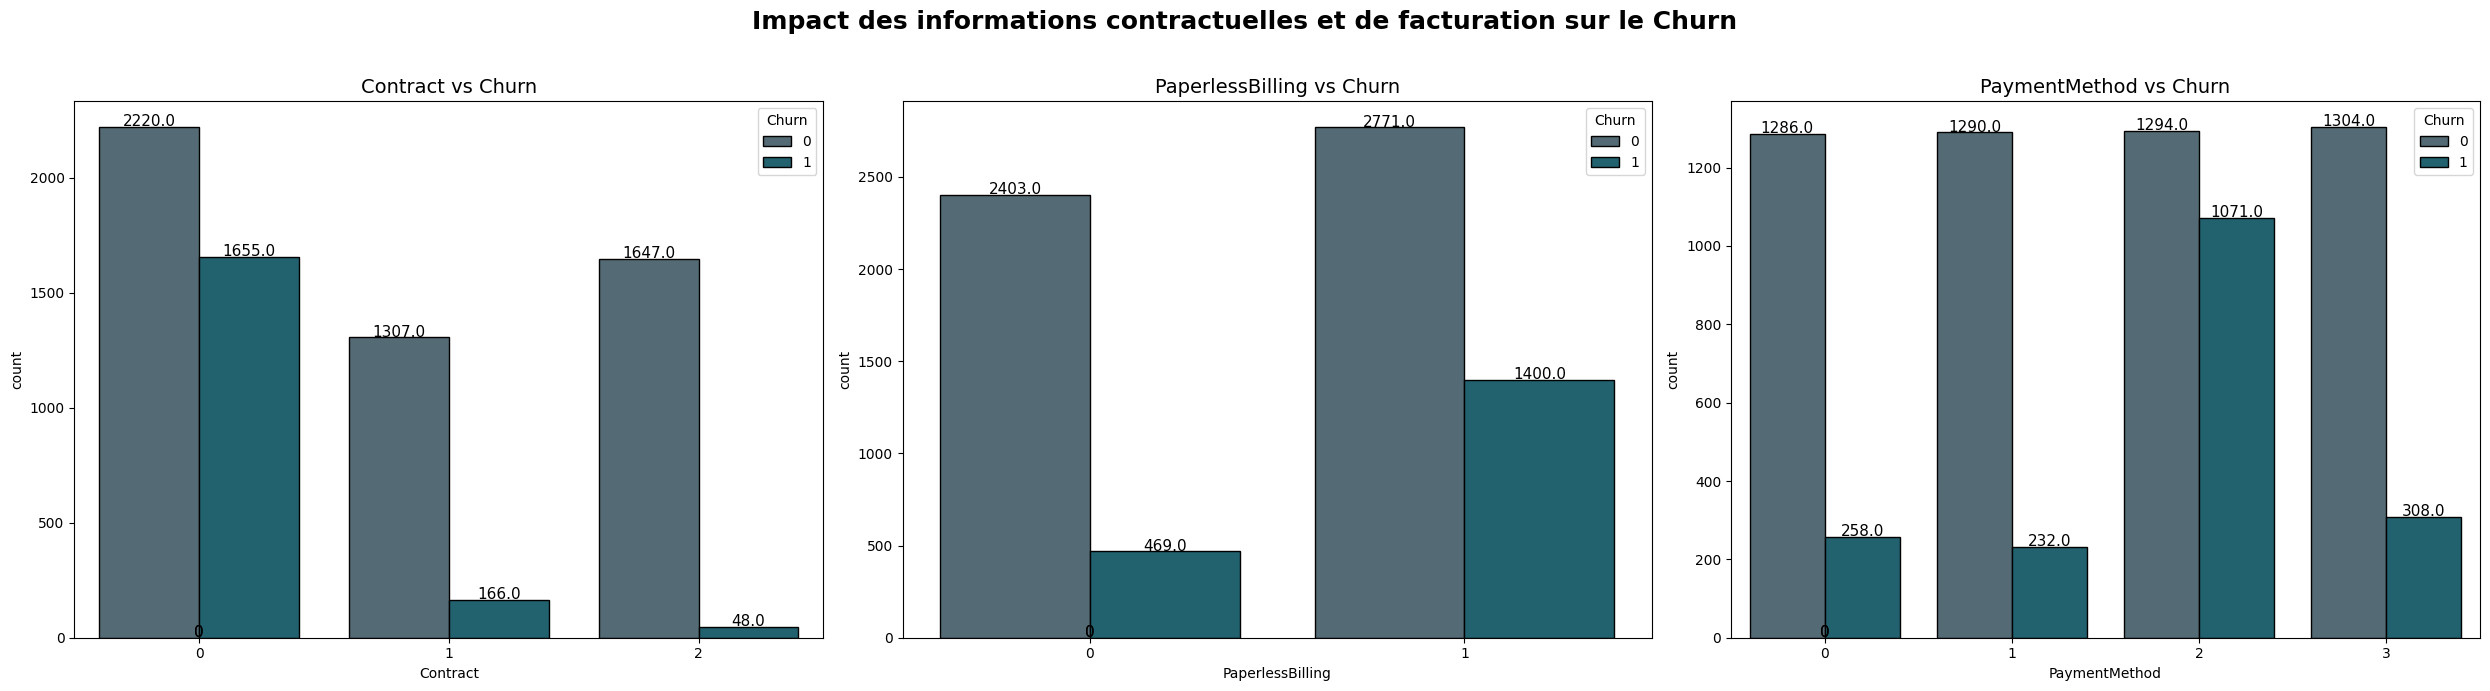

In [45]:
# Variables du groupe 3
billing_features = l3  # ['Contract', 'PaperlessBilling', 'PaymentMethod']

# Figure 1 ligne × 3 colonnes
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

for i, col in enumerate(billing_features):
    ax = axes[i]
    sns.countplot(x=col, data=df, hue="Churn",
                  palette=colors, edgecolor='black', ax=ax)

    # Ajout les annotations
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width()/2,
                rect.get_height() + 2,
                rect.get_height(),
                ha='center', fontsize=11)

    ax.set_title(f"{col} vs Churn", fontsize=14)

plt.suptitle("Impact des informations contractuelles et de facturation sur le Churn",
             fontsize=18, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<small>

#### Impact des Informations Contractuelles et de Facturation sur le Churn

- **Contract** : Les clients avec un contrat **mensuel** affichent un taux de churn nettement plus élevé que ceux ayant un contrat d’un ou deux ans.  
Les contrats plus longs semblent favoriser la fidélité client.  

- **PaperlessBilling** : Les clients ayant opté pour la **facturation électronique** présentent une proportion de churn plus importante que ceux utilisant la facturation papier.  
Cela peut refléter une corrélation avec le profil digital des clients, potentiellement plus volatils.  

- **PaymentMethod** : Les clients payant par **chèque électronique** se distinguent par un taux de churn plus élevé que ceux utilisant d’autres méthodes (virement automatique, carte bancaire automatique, chèque papier).  
Ce mode de paiement peut signaler une population moins fidèle ou plus sensible aux coûts.  

**En résumé** : Les choix contractuels et de facturation constituent des leviers majeurs de la fidélisation.  
Les contrats longue durée et certains modes de paiement (automatisés) sont associés à une rétention plus forte, tandis que la facturation électronique et le paiement par chèque électronique corrèlent avec un risque accru de résiliation.


<small>

#### Analyse des Variables Catégorielles en Relation avec le Churn

Cette analyse se concentre sur l’impact des **variables catégorielles** dans le cadre du churn.  
L’objectif est d’identifier des **patterns**, des **corrélations** et des **facteurs influents** parmi ces variables, afin d’orienter des stratégies efficaces de **fidélisation client**.

---

##### 🔹 Groupe 1 : Informations Client
Ce premier regroupement explore la relation entre les informations personnelles des clients et les cas de churn.  
Les variables étudiées sont :  
- `Gender`  
- `SeniorCitizen`  
- `Partner`  
- `Dependents`  

L’analyse de ces attributs vise à mettre en évidence d’éventuelles tendances ou associations entre les caractéristiques démographiques et la probabilité de résiliation.


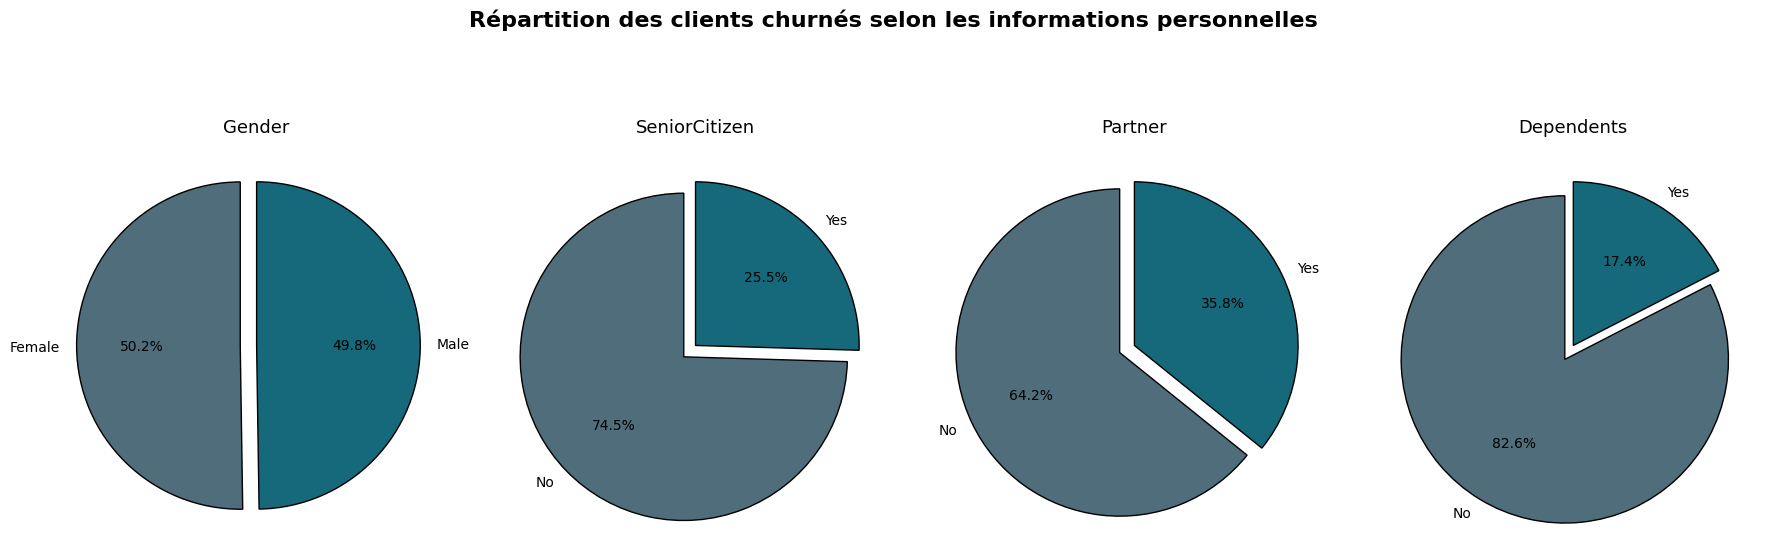

In [46]:
# Calcul des répartitions (% parmi les churnés)
gender = df[df['Churn'] == 1]['gender'].value_counts(normalize=True) * 100
seniorcitizen = df[df['Churn'] == 1]['SeniorCitizen'].value_counts(normalize=True) * 100
partner = df[df['Churn'] == 1]['Partner'].value_counts(normalize=True) * 100
dependents = df[df['Churn'] == 1]['Dependents'].value_counts(normalize=True) * 100

# Listes pour les tracés
features = [gender, seniorcitizen, partner, dependents]
labels_list = [
    ['Female', 'Male'],
    ['No', 'Yes'],
    ['No', 'Yes'],
    ['No', 'Yes']
]
titles = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents']

# Figure 1 ligne × 4 colonnes
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for i, ax in enumerate(axes):
    ax.pie(features[i],
           labels=labels_list[i],
           autopct='%1.1f%%',
           startangle=90,
           explode=(0.1, 0),
           colors=colors,
           wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
    ax.set_title(titles[i], fontsize=13)

plt.suptitle("Répartition des clients churnés selon les informations personnelles",
             fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


<small>

#### Analyse des Informations Personnelles des Clients Churnés

- **Gender** : La répartition est quasiment équilibrée entre hommes (**49,8%**) et femmes (**50,2%**).  
  Le genre n’apparaît pas comme un facteur déterminant du churn.  

- **SeniorCitizen** : Près d’un quart (**25,5%**) des clients churnés sont des seniors, tandis que la majorité (**74,5%**) ne le sont pas.  
  Les seniors sont légèrement surreprésentés dans les cas de churn.  

- **Partner** : Plus de **64,2%** des clients churnés n’ont pas de partenaire contre **35,8%** qui en ont un.  
  L’absence de partenaire semble corrélée à un risque plus élevé de résiliation.  

- **Dependents** : Une large majorité (**82,6%**) des clients churnés n’ont pas de personnes à charge.  
  Les clients sans personnes à charge sont nettement plus enclins à résilier leur contrat.  

**Conclusion** : Si le genre n’a pas d’impact significatif, les caractéristiques liées à la **situation familiale** (Partenaire, Personnes à charge) et à l’**âge** (SeniorCitizen) semblent influencer la probabilité de churn.


<small>

#### 🔹 Groupe 2 : Services Souscrits par le Client

Dans ce groupe, nous examinons la relation entre les **services souscrits** par les clients et les cas de churn.  
Les variables catégorielles étudiées sont :  

- `PhoneService`  
- `MultipleLines`  
- `InternetService`  
- `StreamingTV`  
- `StreamingMovies`  

L’objectif est d’identifier des **patterns** et des **corrélations** au sein de ces attributs liés aux services, afin de mieux comprendre leur rôle dans la résiliation des contrats.


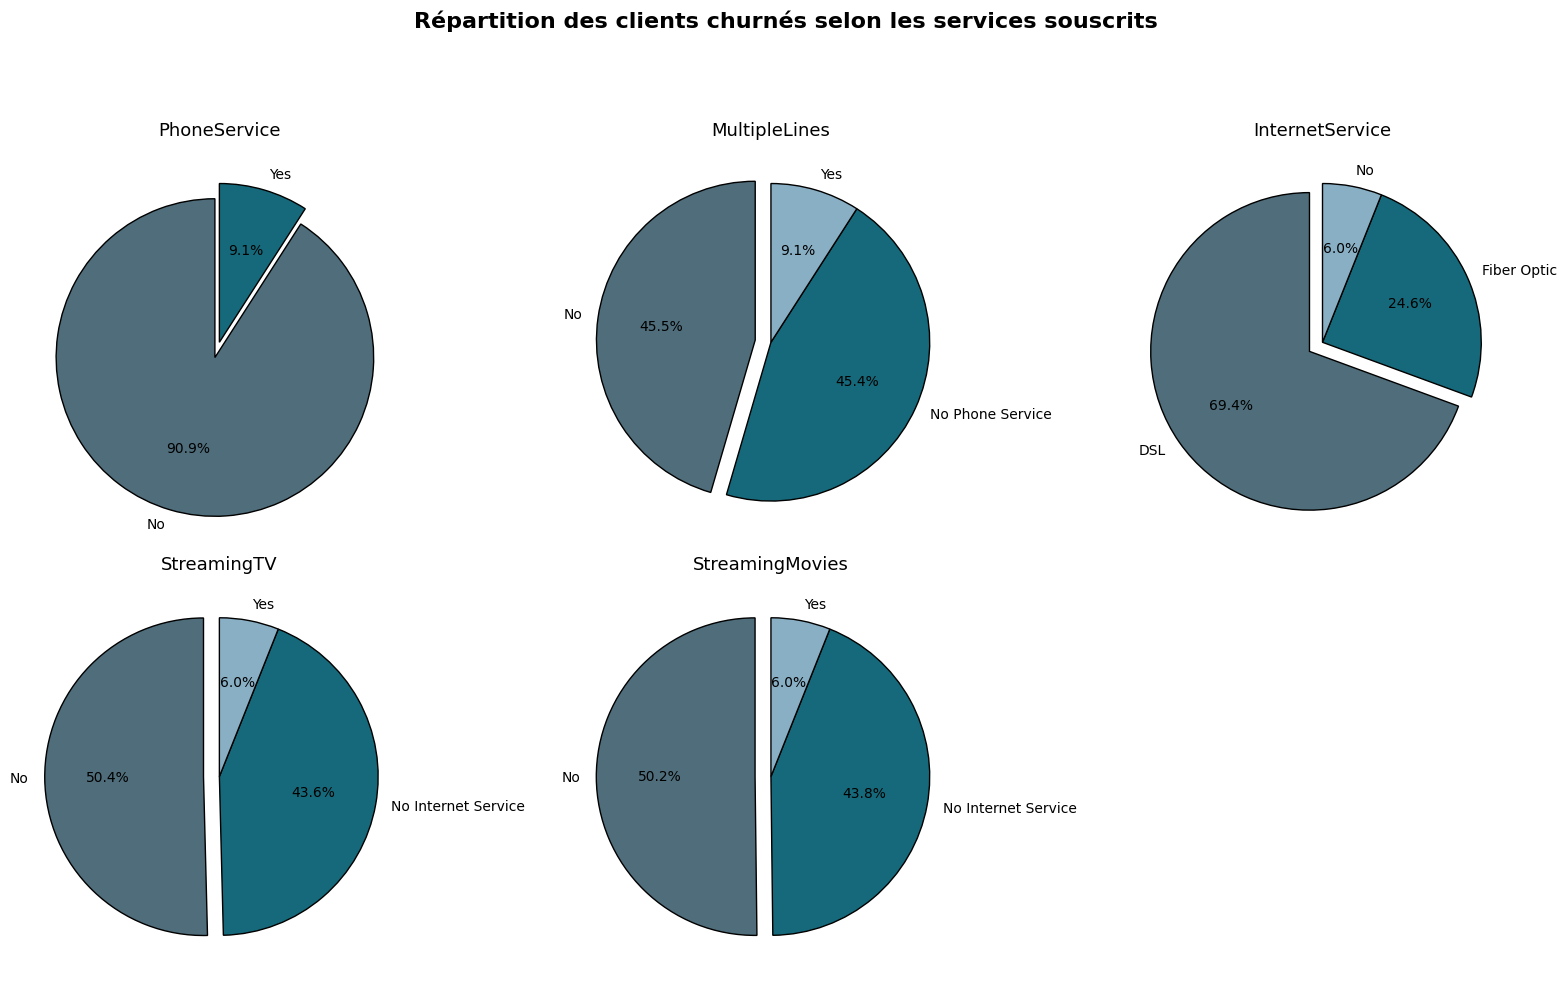

In [47]:
import matplotlib.pyplot as plt

# Palette 
colors = ['#4F6D7A', '#16697A', '#89AFC5']  
# Services souscrits et labels associés
service_features = {
    "PhoneService": ['No', 'Yes'],
    "MultipleLines": ['No', 'No Phone Service', 'Yes'],
    "InternetService": ['DSL', 'Fiber Optic', 'No'],
    "StreamingTV": ['No', 'No Internet Service', 'Yes'],
    "StreamingMovies": ['No', 'No Internet Service', 'Yes']
}

# Figure : 2 lignes × 3 colonnes 
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, (feature, labels) in enumerate(service_features.items()):
    # Répartition (% parmi churnés)
    values = df[df['Churn'] == 1][feature].value_counts(normalize=True) * 100
    
    axes[i].pie(values,
                labels=labels,
                autopct='%1.1f%%',
                startangle=90,
                explode=[0.1 if j == 0 else 0 for j in range(len(labels))],
                colors=colors[:len(labels)],
                wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
    axes[i].set_title(feature, fontsize=13)

# Suppression du dernier subplot vide
fig.delaxes(axes[-1])

plt.suptitle("Répartition des clients churnés selon les services souscrits",
             fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


<small>

#### Analyse des Services Souscrits par les Clients Churnés

- **PhoneService** : Une très grande majorité des clients churnés (**90,9%**) disposaient déjà d’un service téléphonique.  
Le PhoneService seul ne semble pas être un facteur déterminant de fidélisation.  

- **MultipleLines** : La répartition est presque équilibrée entre les clients avec (**45,4%**) et sans (**45,5%**) ligne supplémentaire. Seuls **9,1%** des churnés avaient explicitement plusieurs lignes.  
Ce service ne joue pas un rôle majeur dans la rétention.  

- **InternetService** : Parmi les churnés, la majorité utilisait un accès **DSL (69,4%)**, suivie par **la fibre optique (24,6%)**.  
Les clients fibre semblent proportionnellement plus sujets au churn, possiblement en lien avec des attentes plus fortes en termes de qualité/prix.  

- **StreamingTV et StreamingMovies** : Les proportions sont similaires : environ **50%** des churnés n’utilisaient pas ces services, **44%** n’avaient pas d’accès Internet, et seuls **6%** utilisaient activement ces options.  
Ces services ne sont pas en eux-mêmes des facteurs de fidélisation, mais leur absence peut refléter une moindre implication du client.  

**Conclusion** :  
Les services de base comme **PhoneService** et **MultipleLines** ne discriminent pas vraiment les clients churnés.  
En revanche, la nature du **service Internet** joue un rôle notable : les clients fibre présentent un risque accru de résiliation, ce qui mérite une attention particulière.


<small>

#### 🔹 Groupe 3 : Conditions Contractuelles et Préférences de Facturation

Ce groupe analyse la relation entre les **modalités contractuelles**, les **préférences de facturation** et les **méthodes de paiement** dans le contexte du churn.  
Les variables catégorielles étudiées sont :  

- `Contract`  
- `PaperlessBilling`  
- `PaymentMethod`  

L’objectif est de mettre en évidence des **patterns** et **corrélations** entre ces choix contractuels/financiers et les cas de résiliation, afin d’identifier des leviers potentiels de **fidélisation client**.


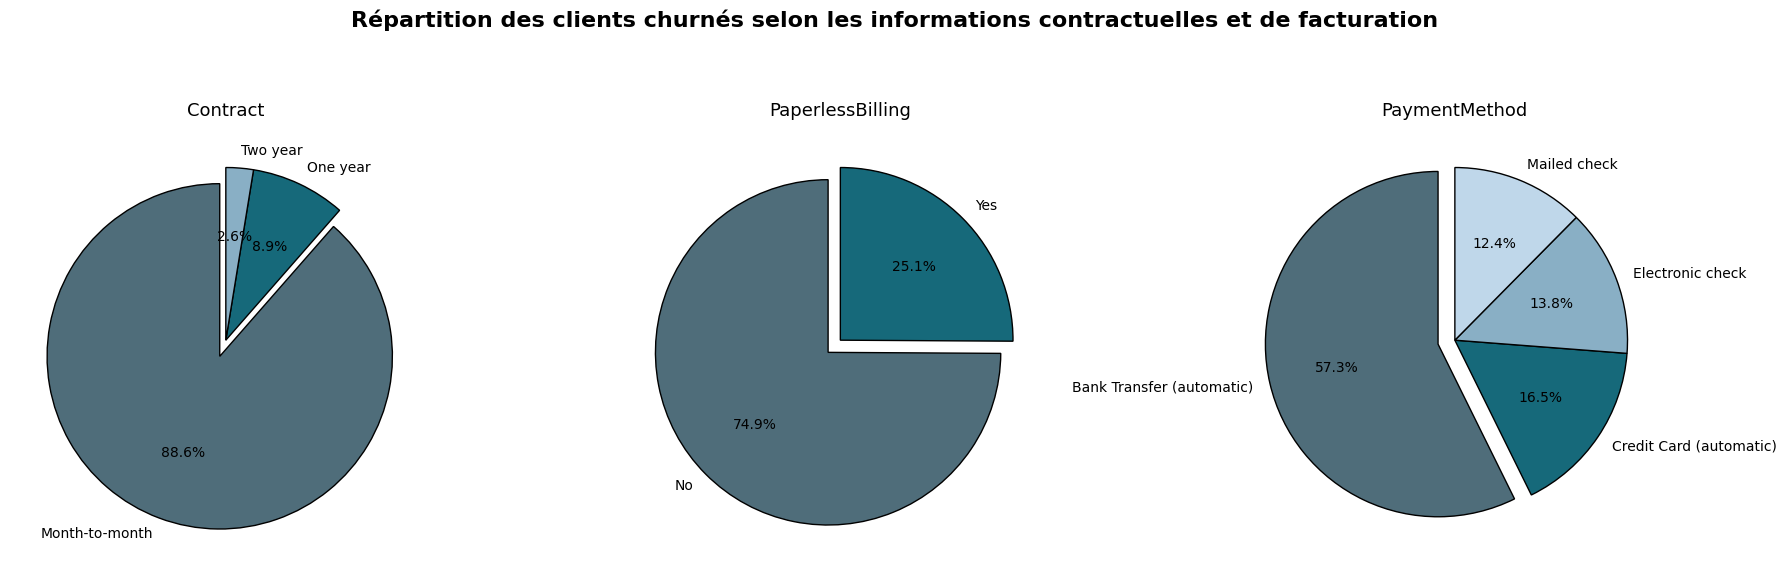

In [48]:
# Palette 
colors = ['#4F6D7A', '#16697A', '#89AFC5', '#BFD7EA']

# Calcul des proportions (% parmi les churnés)
contract = df[df['Churn'] == 1]['Contract'].value_counts(normalize=True) * 100
paperlessbilling = df[df['Churn'] == 1]['PaperlessBilling'].value_counts(normalize=True) * 100
paymentmethod = df[df['Churn'] == 1]['PaymentMethod'].value_counts(normalize=True) * 100

# Features et labels
features = [contract, paperlessbilling, paymentmethod]
labels_list = [
    ['Month-to-month', 'One year', 'Two year'],
    ['No', 'Yes'],
    ['Bank Transfer (automatic)', 'Credit Card (automatic)', 'Electronic check', 'Mailed check']
]
titles = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# Figure 1 ligne × 3 colonnes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ax in enumerate(axes):
    ax.pie(features[i],
           labels=labels_list[i],
           autopct='%1.1f%%',
           startangle=90,
           explode=[0.1 if j == 0 else 0 for j in range(len(labels_list[i]))],
           colors=colors[:len(labels_list[i])],
           wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
    ax.set_title(titles[i], fontsize=13)

plt.suptitle("Répartition des clients churnés selon les informations contractuelles et de facturation",
             fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


<small>

Contract

🔹 La quasi-totalité des clients churnés (88,6%) étaient sous contrat mensuel.

🔹 Les contrats d’un an (8,9%) et de deux ans (2,6%) présentent un taux de churn beaucoup plus faible, suggérant que les engagements longs réduisent significativement le risque de résiliation.

PaperlessBilling

🔹 74,9% des churnés n’utilisaient pas la facturation électronique.

🔹 Cela laisse penser que les clients attachés au support papier pourraient être plus volatils, tandis que la facturation dématérialisée peut favoriser la fidélisation.

PaymentMethod

🔹 La majorité des churnés (57,3%) utilisaient le virement bancaire automatique.

🔹 Le chèque électronique (13,8%) et le chèque papier (12,4%) concernent une part non négligeable de churn, 
traduisant peut-être une population plus sensible ou moins digitalisée.
🔹 La carte bancaire automatique (16,5%) reste un mode intermédiaire.

<small>

#### Distribution des variables numériques
Dans cette analyse, nous explorons la distribution des variables numériques afin de mieux comprendre la dispersion et les caractéristiques des attributs quantitatifs du jeu de données.


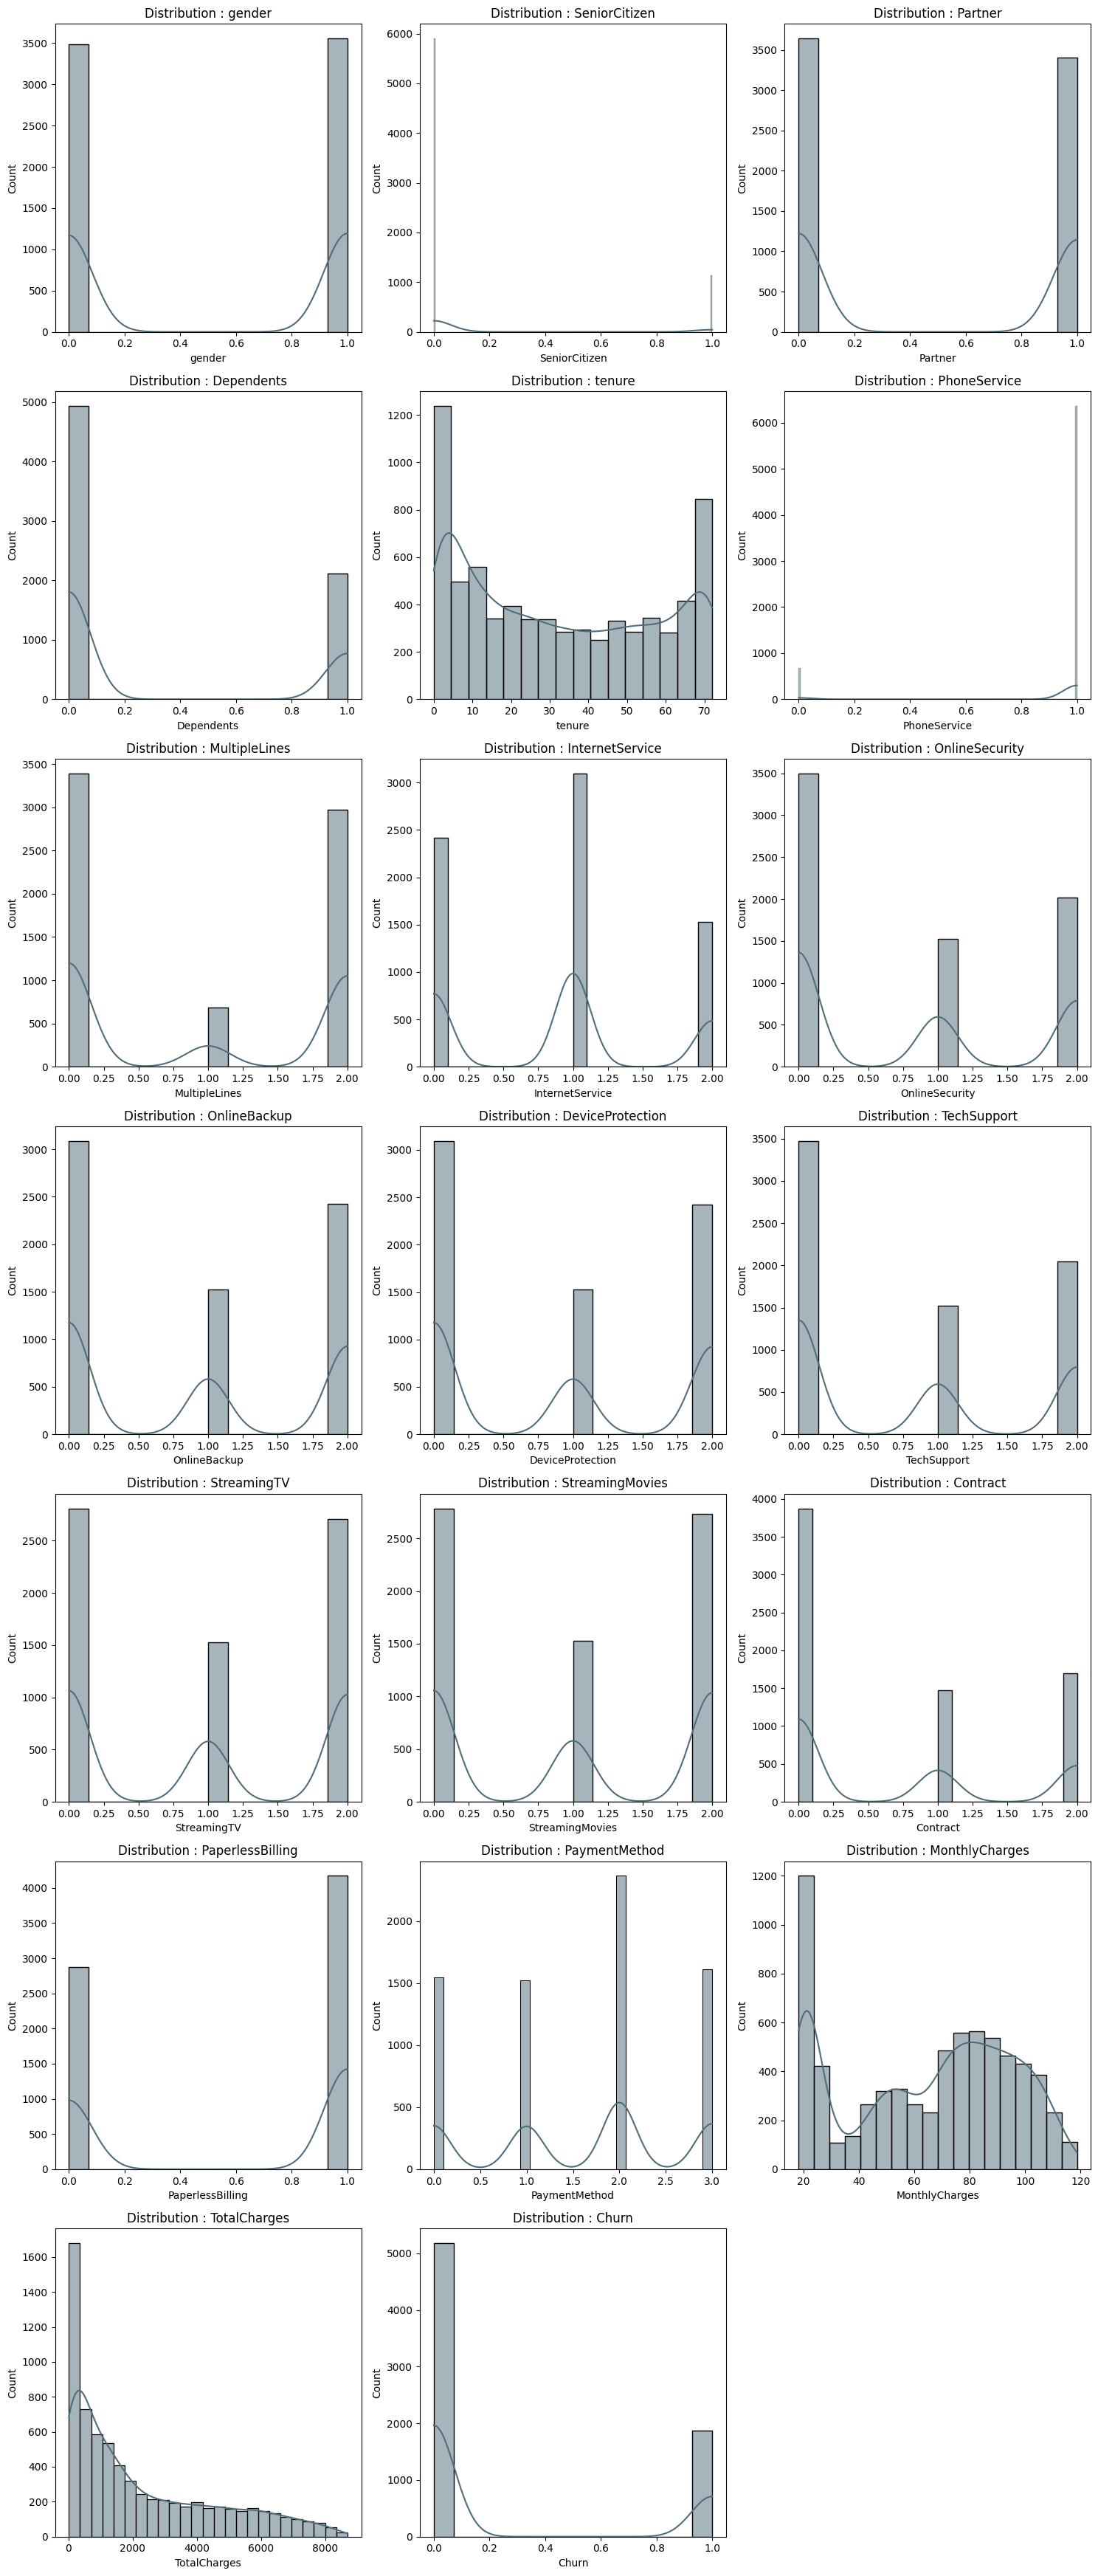

In [49]:
n_features = len(numerical_features)
ncols = 3
nrows = (n_features + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], kde=True, color=colors[0], ax=axes[i])
    axes[i].set_title(f"Distribution : {feature}")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<small>

- **Tenure (ancienneté du client)**  
  La distribution présente une concentration de clients aux extrêmes : beaucoup de nouveaux clients (tenure faible) et de clients très anciens (tenure élevé), tandis que la proportion est plus faible au milieu.  
  Cela peut indiquer que les clients quittent rapidement après leur arrivée, ou restent fidèles très longtemps.

- **MonthlyCharges (charges mensuelles)**  
  La distribution est bimodale avec deux pics : l’un autour de 20–30 et l’autre autour de 80–100.  
  Cela reflète probablement l’existence de différentes gammes d’offres (basiques vs premium).

- **TotalCharges (charges totales)**  
  La distribution est fortement asymétrique à droite : la majorité des clients ont dépensé peu, mais certains ont accumulé des montants très élevés.  
  Les outliers (charges très élevées) pourraient correspondre à des clients anciens ou à forte consommation.


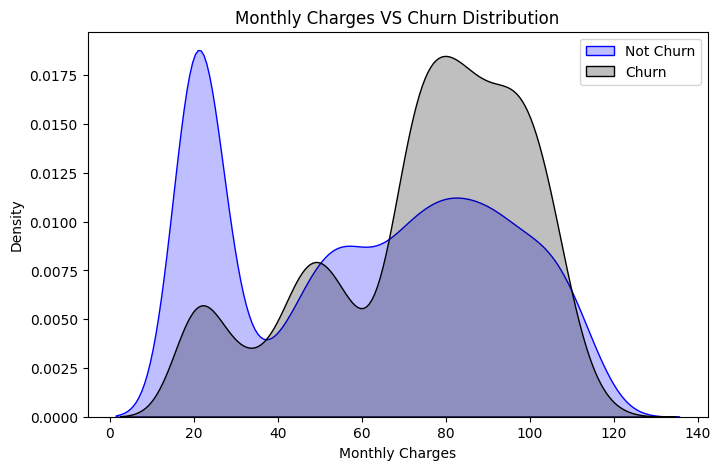

In [50]:
plt.figure(figsize=(8,5))

ax = sns.kdeplot(
    df.loc[df["Churn"] == 0, "MonthlyCharges"], 
    color="blue", fill=True, label="Not Churn"
)
ax = sns.kdeplot(
    df.loc[df["Churn"] == 1, "MonthlyCharges"], 
    color="black", fill=True, label="Churn"
)

ax.legend(loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Monthly Charges VS Churn Distribution')
plt.show()


<small>

L’analyse des distributions montre que :  

- Les clients **sans churn** (Not Churn) sont plus concentrés sur les **charges mensuelles faibles** (autour de 20–30).  
- Les clients qui **churnent** sont davantage représentés dans les **charges mensuelles élevées** (80–100).  
- On observe donc une tendance : **plus les charges mensuelles sont élevées, plus la probabilité de churn augmente**.

Cette relation met en évidence un risque d’insatisfaction chez les clients aux offres coûteuses, ce qui pourrait guider des actions de rétention (offres promotionnelles, ajustement de services).


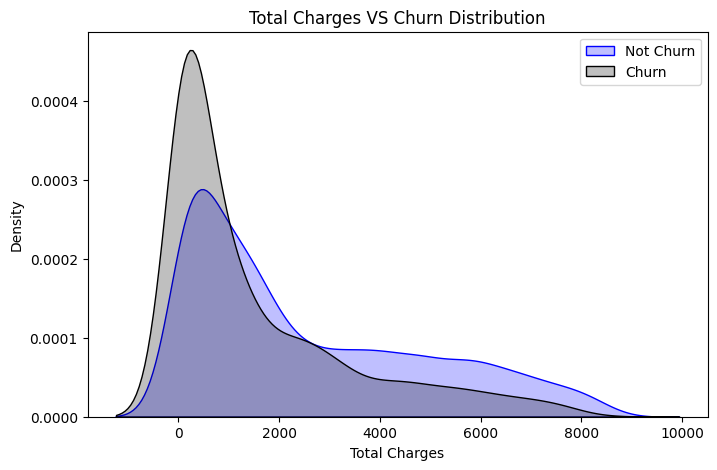

In [51]:
plt.figure(figsize=(8,5))

ax = sns.kdeplot(
    df.loc[df["Churn"] == 0, "TotalCharges"],
    color="blue", fill=True, label="Not Churn"
)
ax = sns.kdeplot(
    df.loc[df["Churn"] == 1, "TotalCharges"],
    color="black", fill=True, label="Churn"
)

ax.legend(loc="upper right")
ax.set_ylabel("Density")
ax.set_xlabel("Total Charges")
ax.set_title("Total Charges VS Churn Distribution")
plt.show()


<small>

- Les clients **avec churn** sont concentrés sur les **faibles valeurs de TotalCharges**.  
  Cela indique qu’ils sont généralement récents (tenure faible) et n’ont pas encore accumulé beaucoup de dépenses.  

- Les clients **sans churn (Not Churn)** présentent une distribution plus étendue avec des **charges totales plus élevées**, signe d’une plus grande fidélité.  

- Globalement, la probabilité de churn diminue à mesure que les **charges totales augmentent**, traduisant un effet de fidélisation naturelle.


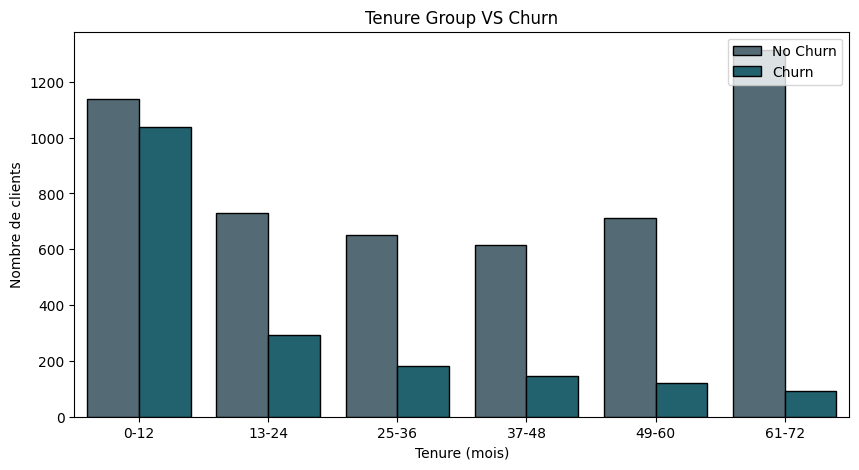

In [52]:
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], 
                            labels=['0-12','13-24','25-36','37-48','49-60','61-72'])

plt.figure(figsize=(10,5))
sns.countplot(x='TenureGroup', data=df, hue='Churn', palette=colors, edgecolor='black')
plt.title('Tenure Group VS Churn')
plt.xlabel('Tenure (mois)')
plt.ylabel('Nombre de clients')
plt.legend(['No Churn', 'Churn'], loc='upper right')
plt.show()

<small>

- Le **taux de churn est plus élevé parmi les clients récents** (0 à 12 mois).  
- Au fur et à mesure que l’ancienneté augmente, le churn diminue progressivement.  
- Les clients avec une **ancienneté supérieure à 5 ans** présentent une probabilité de churn beaucoup plus faible.  

Cela confirme un comportement classique : les clients sont les plus vulnérables au churn en début de relation, tandis que la fidélité augmente avec le temps.


<small>

#### Relations entre variables quantitatives et la cible (Churn)

<small>

### Vue d’ensemble de l’Analyse Exploratoire (EDA)

Dans l’analyse du churn client, plusieurs variables catégorielles révèlent des tendances importantes, essentielles pour concevoir des stratégies de rétention efficaces :

- **Données démographiques**  
  - Les **hommes** présentent un risque de churn **plus élevé** que les femmes.  
  - Les **seniors (Senior Citizens)** affichent un **taux de churn plus faible** que les plus jeunes.  
  - Les clients **sans partenaire ni personnes à charge** sont davantage susceptibles de churner.  

- **Services**  
  - La présence d’un **service téléphonique** et de **lignes multiples** est associée à un **taux de churn plus bas**.  
  - Les utilisateurs d’**Internet par fibre optique** sont **plus enclins à churner** que ceux utilisant l’ADSL.  
  - L’**absence de services additionnels** (sécurité en ligne, sauvegarde en ligne, etc.) est un facteur de **churn plus élevé**.  

- **Contrats et facturation**  
  - Les contrats **mensuels (month-to-month)** présentent les **taux de churn les plus élevés**, alors que les contrats d’**un an ou deux ans** affichent des taux nettement plus faibles.  
  - Les clients ayant choisi la **facturation sans papier (PaperlessBilling)** présentent un risque accru de churn.  

- **Méthodes de paiement**  
  - Les utilisateurs de **chèques électroniques** sont les plus exposés au churn, suivis de ceux qui utilisent les **chèques postaux**.  
  - Les paiements **automatiques** (prélèvement bancaire ou carte de crédit) sont associés à un **churn plus faible**.  

Ces hiérarchies mettent en évidence des leviers clés pour des **stratégies de rétention ciblées**, notamment au niveau des contrats, des modes de paiement et des services associés.  

<small>

### Enrichissement des variables (Feature Engineering)

#### Gestion du déséquilibre des classes avec SMOTE

La variable cible (`Churn`) est déséquilibrée, ce qui peut biaiser les modèles prédictifs. Deux grandes approches sont possibles :

- **Sous-échantillonnage (Undersampling)**  
  Réduire la taille de la classe majoritaire en supprimant des observations.  

- **Sur-échantillonnage (Oversampling)**  
  Augmenter la taille de la classe minoritaire en dupliquant ou en générant artificiellement des observations.  

Après analyse, le choix s’est porté sur le **sur-échantillonnage**.  

Pour équilibrer les classes, nous utilisons la technique **SMOTE (Synthetic Minority Oversampling Technique)** via la bibliothèque `imbalanced-learn (imblearn)`.  

